In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from timm.models import create_model
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor

def to_tensor(img):
    transform_fn = Compose([Resize(249, 3), CenterCrop(224), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    return transform_fn(img)

def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

/home/eranario/miniconda3/envs/diffusers/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


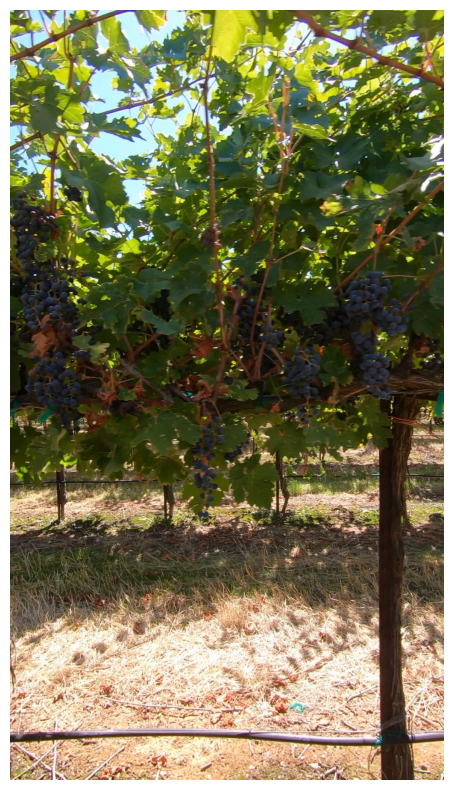

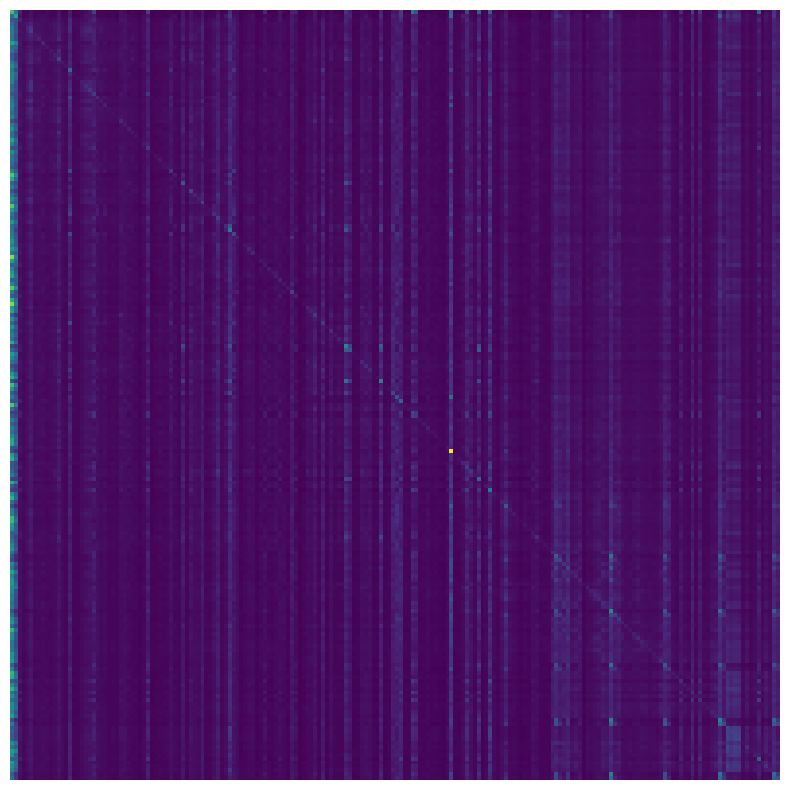

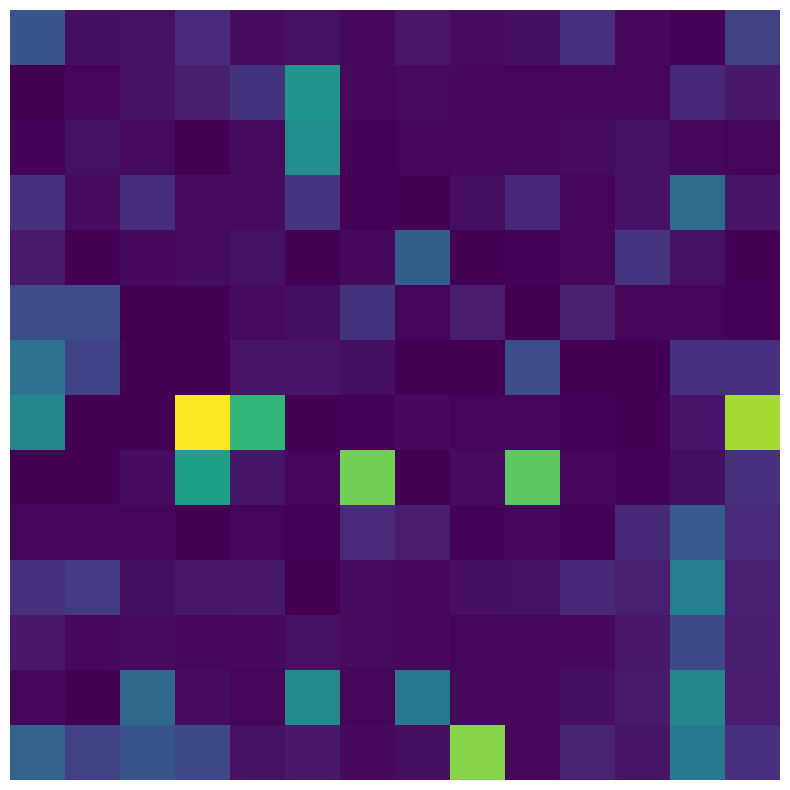

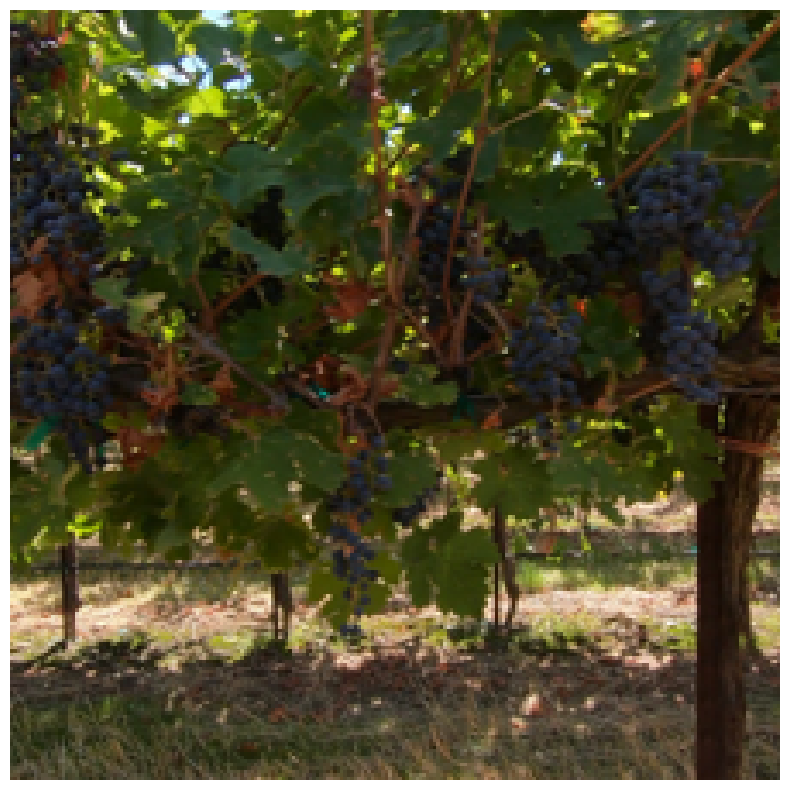

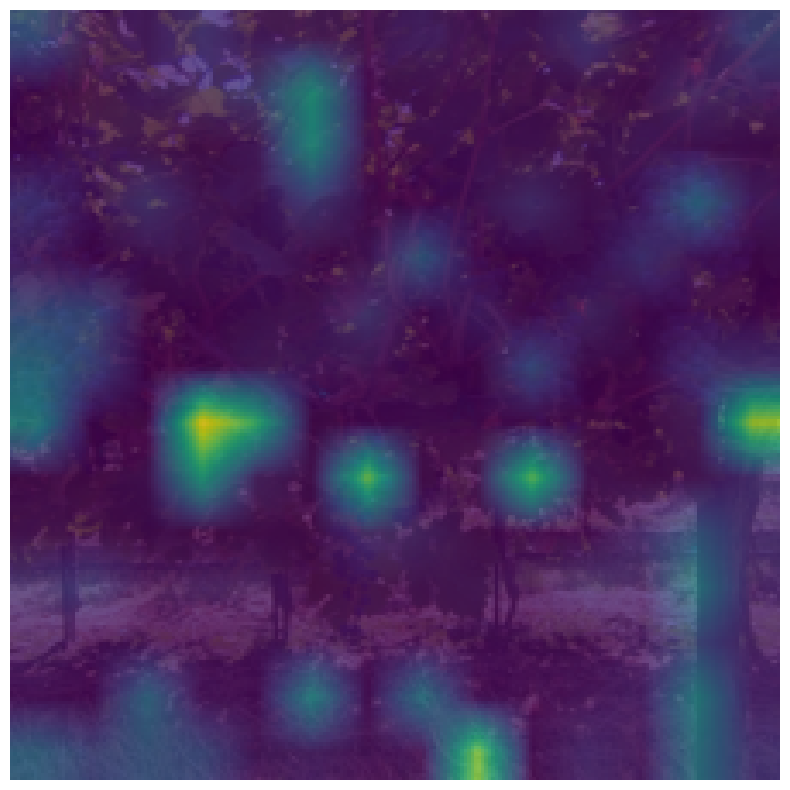

In [3]:
img = Image.open('/data2/eranario/data/yolo_grl_data/CropGANData/detection_datasets/BordenDayRow/train/images/GH010070000312.jpg')
x = to_tensor(img)

model = create_model('deit_small_distilled_patch16_224', pretrained=True)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

show_img(img)
show_img(attn_map)
show_img(cls_weight)
show_img(img_resized)
show_img2(img_resized, cls_resized, alpha=0.8)

In [8]:
# model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
model.blocks[-1].attn.attn_map.shape

torch.Size([1, 6, 198, 198])

In [9]:
model.blocks[-1].attn.attn_map.mean(dim=1).shape

torch.Size([1, 198, 198])

In [10]:
model.blocks[-1].attn.cls_attn_map.shape

torch.Size([1, 6, 196])